In [5]:
# Source du code qui suit : https://towardsdatascience.com/k-nearest-neighbors-classification-from-scratch-with-numpy-cb222ecfeac1

from sklearn.model_selection import train_test_split
import numpy as np 
import scipy.io as sp
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

dataSet = sp.loadmat('breastw.mat')
X = dataSet['X']
y = dataSet['y']

X=StandardScaler().fit_transform(X)
model=PCA(n_components=2)
X=model.fit_transform(X)

#Séparation des données d'apprentissage et des données tests
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)
#Création de la fonction calculant la distance euclidienne entre 2 points
def euclidian_distance(a, b):
    return np.sqrt(np.sum((a-b)**2, axis=1))


#fonction pour trouver les k plus proches voisins de chaque points test
def kneighbors(X_test, return_distance=False): #False si on ne pondère pas par la suite avec les distance, True si on pondère
       
        n_neighbors = 5  #choix de l'hyperparamètre k 
        dist = [] #matrice des distances des knn pour chaque points des données tests
        neigh_ind = [] #matrice des distances des indices des knn pour chaque points des données tests
        
        point_dist = [euclidian_distance(x_test, X_train) for x_test in X_test]  #On stocke les données des distances euclidiennes entre chaque points dans cette matrice
            #chaque ligne correspond à une liste de distances entre un point donné de test et toutes les données d'apprentissage
        
        for row in point_dist:      #On parcours chaque ligne de la matrice des distances pour pouvoir trier les distances par ordre croissant
            enum_neigh = enumerate(row)  #Avant de trier, on énumère chaque ligne pour ne pas perdre les indices des points de données d'apprentissage avec lesquels nous avons calculé les distances
            sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:n_neighbors] #Contient les k plus proches voisins de chaque données test, triés en fonction de leurs distances euclidiennes
                        #matrice de type :(index,valeur)
            ind_list = [tup[0] for tup in sorted_neigh]  #on extrait les indices de sorted_neigh
            dist_list = [tup[1] for tup in sorted_neigh]  #on extrait les distances de sorted_neigh
    
            dist.append(dist_list)
            neigh_ind.append(ind_list)
        
        if return_distance: #si on pondère le label avec les distances, on a besoin de connaître les distances au point des 5 voisins
            return np.array(dist), np.array(neigh_ind)
        
        return np.array(neigh_ind)  #si on ne pondère pas avec les points, on a seulement besoin de l'indice du voisin

#print(X_test,X_train,y_test,y_train)

print(kneighbors(X_test, return_distance=False))    

[[ 51 310  44  36 284]
 [ 21  31  32  58 116]
 [ 33 203 206 209  29]
 ...
 [107 226 227 237 252]
 [101 184  39 107 226]
 [162  67  88 195 183]]


In [6]:
#fonction pour prédire la classe de chaques point test
#cette fonction pondère l'importance de chaque point d'apprentissage en fonction de leur distance au point test

def predict(X_test, weights='uniform'):
        
        class_num = 2
        
        if weights=='uniform': #si on ne pondère pas, donc poids uniforme
            neighbors = kneighbors(X_test)
            y_pred = np.array([np.argmax(np.bincount(np.concatenate(y_train[neighbor]))) for neighbor in neighbors]) #on cherche les indices des voisins, puis on obtient leur label. Chaque ligne de neighbor correspond à l'ensemble des voisins de chaque point de données de test
            #avec bincount, on compte le nombre d'occurence des 0 et des 1 parmi les labels des k voisins de chaque X_test
            #on prend ensuite le label qui à la plus grande occurence parmi les k voisins
            #On réitère pour chaque x_test et on stocke le label prédit dans une matrice        
            return (y_pred)
    
        if weights=='distance': #si on pondère
        
            dist, neigh_ind = kneighbors(X_test, return_distance=True) #On récupère les distances et les indices des k plus proches voisins de chaque X_test
            
            inv_dist = 1/dist
            # le voisin le plus proche du point de données de test a le plus de poids (vote) proportionnel à l'inverse de leurs distances
            
            mean_inv_dist = inv_dist / np.sum(inv_dist, axis=1)[:, np.newaxis] # inverse moyen des distances entre voisins
            proba = []
            
            #calcul des probabilités de classe pour chaque point de données de test
            for i, row in enumerate(mean_inv_dist):
                
                row_pred = y_train[neigh_ind[i]] #on récupère le label des k plus proches voisins de chaque X_test
                
                for k in range(class_num):
                    indices = np.where(row_pred==k)
                    prob_ind = np.sum(row[indices[1]]) 
                    proba.append(np.array(prob_ind))
        
            predict_proba = np.array(proba).reshape(X_test.shape[0], class_num)
            
            y_pred = np.array([np.argmax(item) for item in predict_proba])
            
            return y_pred


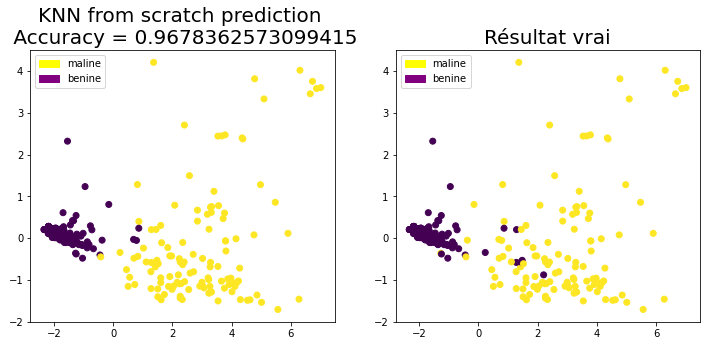

In [7]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

result2 = accuracy_score(y_test,predict(X_test, weights='uniform'))
#graphique 
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.scatter(X_test[:,0],X_test[:,1],c=predict(X_test, weights='uniform'))
plt.title("KNN from scratch prediction \n Accuracy = {}".format(result2), size=20)
maline = mpatches.Patch(color='yellow', label='maline')
benine = mpatches.Patch(color='purple', label='benine')
plt.legend(handles=[maline,benine])

plt.subplot(1, 2, 2)
plt.scatter(X_test[:,0],X_test[:,1],c=y_test)
plt.title("Résultat vrai", size=20)
maline = mpatches.Patch(color='yellow', label='maline')
benine = mpatches.Patch(color='purple', label='benine')
plt.legend(handles=[maline,benine])
plt.show()
